# Validation of simulation

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\bra}[1]{\langle#1|}$
$\newcommand{\ketbra}[2]{| #1 \rangle\langle #2 |}$

In [1]:
import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt
from rqutils.math import matrix_exp
import rqutils.paulis as paulis
import qudit_sim

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=100., amplitude=0.1)

In [3]:
qudit_sim.print_hamiltonian(hgen.generate(rwa=True))

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 |\end{align}")

In [4]:
e_ops = [qtp.sigmaz()]
result = qudit_sim.pulse_sim(hgen, psi0=qtp.basis(2, 0), tlist=(100, 1), e_ops=e_ops)

For a static Hamiltonian, hgen.make_tlist() generates a list from $0$ to $2 \pi / \sqrt{\mathrm{tr}\frac{H^2}{2^n}}$. We therefore expect a time evolution of $\exp (-i 2\pi X)$.

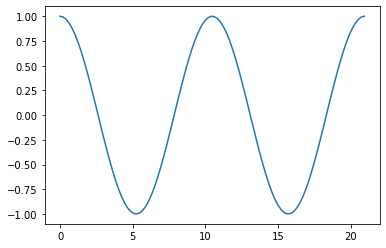

In [5]:
plt.plot(result.times, result.expect[0])

## Single qubit off-resonant drive

In [6]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)

In [7]:
hamiltonian = hgen.generate()
qudit_sim.print_hamiltonian(hamiltonian)

LaTeXRepr("\begin{align}H_{0} & = [\text{(0.30000000000000004 * cos(1.0 * t))}]*  \left( | 0 \rangle\langle 1 | + | 1 \rangle\langle 0 | \right) \\ H_{1} & = [\text{(-0.30000000000000004 * sin(1.0 * t))}]*  \left( -i| 0 \rangle\langle 1 | + i| 1 \rangle\langle 0 | \right)\end{align}")

In the drive frame,

In [8]:
hgen.set_frame('q0', frequency=np.full(1, 101.))
qudit_sim.print_hamiltonian(hgen.generate())

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 | - | 1 \rangle\langle 1 |\end{align}")

Set psi0 to an eigenvector of this Hstatic:

In [9]:
Hstat = hgen.generate()[0].full()
w, v = np.linalg.eigh(Hstat)
psi0 = qtp.Qobj(inpt=v[:, 0])

In [10]:
e_ops = [qtp.sigmax(), qtp.sigmay(), qtp.sigmaz()]
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(100, 2), e_ops=e_ops)

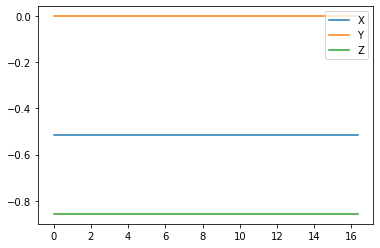

In [11]:
plt.plot(result.times, result.expect[0], label='X')
plt.plot(result.times, result.expect[1], label='Y')
plt.plot(result.times, result.expect[2], label='Z')
plt.legend();

These expectation values correspond to e.g.

$$
\bra{\psi(t)} U_d^{\dagger}(t) X U_d(t) \ket{\psi(t)} = \mathrm{tr} \left[ U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t) X \right].
$$

Because $U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t)$ is a $2 \times 2$ Hermitian matrix, it is completely determined by the three expectation values $\langle X \rangle$, $\langle Y \rangle$, and $\langle Z \rangle$.

In [12]:
components = np.stack((np.zeros_like(result.expect[0]), result.expect[0], result.expect[1], result.expect[2]))
# Compose 200 2x2 matrices from Pauli components
ud_rho_uddag = paulis.compose(components.T, dim=2)

The qudit-frame expectation values can be obtained from these results by

$$
\bra{\psi(t)} U_q^{\dagger}(t) X U_q(t) \ket{\psi(t)} = \mathrm{tr}\left[ U_q(t) U_d^{\dagger}(t) \left( U_d(t) \rho_{\psi}(t) U_d^{\dagger}(t) \right) U_d(t) U_q^{\dagger}(t) X \right]
$$

The unitary to move from the drive frame to the qudit frame is

$$
U_q(t) U_d^{\dagger}(t) = \exp \left(-i \frac{\omega_q - \omega_d}{2} \sigma_z t \right)
$$

In [13]:
tlist = result.times
sigmaz = paulis.paulis(2)[3]
uq_uddag = matrix_exp(-1.j * (100. - 101.) * 0.5 * tlist[:, None, None] * sigmaz[None, ...], hermitian=-1)

In [14]:
ud_uqdag = uq_uddag.transpose((0, 2, 1)).conjugate()
qudit_frame_exp = paulis.components(uq_uddag @ ud_rho_uddag @ ud_uqdag, dim=2).real

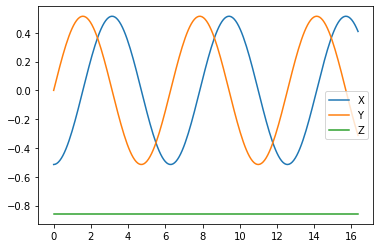

In [15]:
plt.plot(tlist, qudit_frame_exp[:, 1], label='X')
plt.plot(tlist, qudit_frame_exp[:, 2], label='Y')
plt.plot(tlist, qudit_frame_exp[:, 3], label='Z')
plt.legend();

Simulation result in the qudit frame:

In [16]:
hgen.set_frame('q0', frequency=None)
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops)

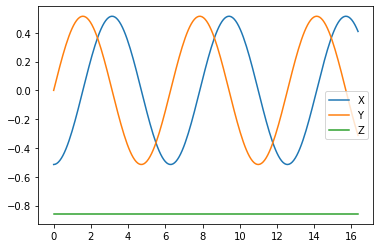

In [17]:
plt.plot(result.times, result.expect[0], label='X')
plt.plot(result.times, result.expect[1], label='Y')
plt.plot(result.times, result.expect[2], label='Z')
plt.legend();

## Single qutrit off-resonance

In [18]:
hgen = qudit_sim.HamiltonianGenerator(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_drive('q0', frequency=101., amplitude=0.1)

In [19]:
hamiltonian = hgen.generate()
qudit_sim.print_hamiltonian(hamiltonian)

LaTeXRepr("\begin{align}H_{0} & = [\text{(0.30000000000000004 * cos(1.0 * t))}]*  \left( | 0 \rangle\langle 1 | + | 1 \rangle\langle 0 | \right) \\ H_{1} & = [\text{(-0.30000000000000004 * sin(1.0 * t))}]*  \left( -i| 0 \rangle\langle 1 | + i| 1 \rangle\langle 0 | \right) \\ H_{2} & = [\text{(0.30000000000000004 * cos(9.0 * t))}]*  \left( 1.414| 1 \rangle\langle 2 | + 1.414| 2 \rangle\langle 1 | \right) \\ H_{3} & = [\text{(-0.30000000000000004 * sin(9.0 * t))}]*  \left( -1.414i| 1 \rangle\langle 2 | + 1.414i| 2 \rangle\langle 1 | \right)\end{align}")

In the drive frame,

In [20]:
hgen.set_frame('q0', frequency=np.full(2, 101.))
qudit_sim.print_hamiltonian(hgen.generate())

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = 0.300| 0 \rangle\langle 1 | + 0.300| 1 \rangle\langle 0 | - | 1 \rangle\langle 1 | + 0.424| 1 \rangle\langle 2 | + 0.424| 2 \rangle\langle 1 | - 10| 2 \rangle\langle 2 |\end{align}")

Set psi0 to an eigenvector of this Hstatic:

In [21]:
Hstat = hgen.generate()[0].full()
w, v = np.linalg.eigh(Hstat)
psi0 = qtp.Qobj(inpt=v[:, 0])

In [22]:
e_ops = [qtp.Qobj(inpt=l) for l in paulis.paulis(3)[1:]]
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(100, 2), e_ops=e_ops)

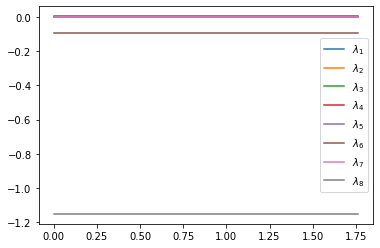

In [23]:
labels = paulis.labels(3)
for exp, label in zip(result.expect, labels[1:]):
    plt.plot(result.times, exp, label=f'${label}$')
plt.legend();

In [24]:
components = np.stack([np.zeros_like(result.expect[0])] + result.expect)
# Compose 200 3x3 matrices from Pauli components
ud_rho_uddag = paulis.compose(components.T, dim=3)

The unitary to move from the drive frame to the qudit frame is

$$
U_q(t) U_d^{\dagger}(t) = e^{i(\omega_q - \omega_d)t} \ketbra{1}{1} + e^{i[2(\omega_q - \omega_d) + \Delta]t} \ketbra{2}{2}
$$

In [25]:
tlist = result.times
gen = np.diag([0., 100. - 101., 2. * (100. - 101.) - 8.])
uq_uddag = matrix_exp(1.j * tlist[:, None, None] * gen[None, ...], hermitian=-1)

In [26]:
ud_uqdag = uq_uddag.transpose((0, 2, 1)).conjugate()
qudit_frame_exp = paulis.components(uq_uddag @ ud_rho_uddag @ ud_uqdag, dim=3).real

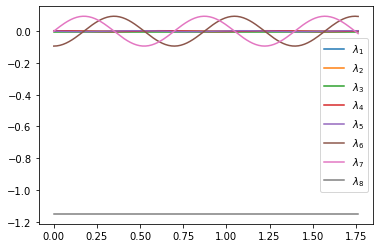

In [27]:
for ilabel, label in enumerate(labels):
    if ilabel == 0:
        continue
    plt.plot(tlist, qudit_frame_exp[:, ilabel], label=f'${label}$')

plt.legend();

Simulation result in the qudit frame:

In [28]:
hgen.set_frame('q0', frequency=None)
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=tlist, e_ops=e_ops)

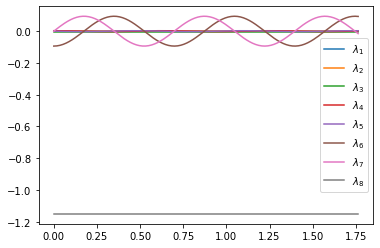

In [29]:
for exp, label in zip(result.expect, labels[1:]):
    plt.plot(result.times, exp, label=f'${label}$')
plt.legend();

## Two qubit cross resonance, no crosstalk

In [30]:
hgen = qudit_sim.HamiltonianGenerator(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110., anharmonicity=-7., drive_amplitude=7., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 0.03)
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=0.5+0.5j)

In [31]:
psi0_0 = qtp.tensor(qtp.basis(2, 0), qtp.basis(2, 0)) # |00>
psi0_1 = qtp.tensor(qtp.basis(2, 1), qtp.basis(2, 0)) # |10>
e_ops = [qtp.tensor(qtp.qeye(2), qtp.sigmay()), qtp.tensor(qtp.qeye(2), qtp.sigmaz())] # IY, IZ
result_0 = qudit_sim.pulse_sim(hgen, psi0=psi0_0, tlist=(100, 2), e_ops=e_ops)
result_1 = qudit_sim.pulse_sim(hgen, psi0=psi0_1, tlist=(100, 2), e_ops=e_ops)

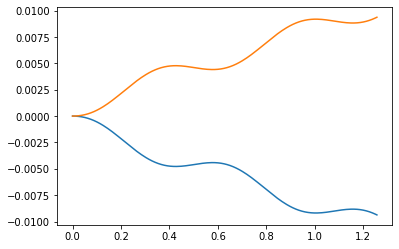

In [32]:
# Cross resonance drive induces a ZX term -> <IY> moves from 0 to opposite directions
plt.plot(result_0.times, result_0.expect[0])
plt.plot(result_1.times, result_1.expect[0]);

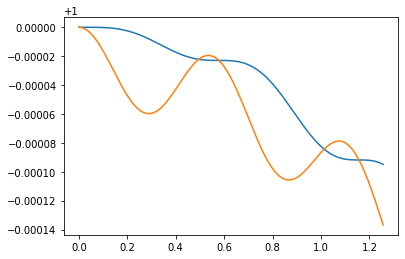

In [33]:
# <IZ> moves from 1 in the same direction
plt.plot(result_0.times, result_0.expect[1])
plt.plot(result_1.times, result_1.expect[1]);

## Two qutrit no drive, frame dependence

When couplings are present, the static Hamiltonian is no longer diagonal, causing a phase drift in the qudit frame. Here we use an unrealistically large coupling to demonstrate the effect by starting with a $\lambda_1$ eigenstate and tracking $\langle \lambda_i I \rangle$.

In [34]:
hgen = qudit_sim.HamiltonianGenerator(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110., anharmonicity=-7., drive_amplitude=7., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3.)

In [35]:
psi0 = qtp.tensor(qtp.Qobj(inpt=np.array([np.sqrt(0.5)] * 2 + [0.])), qtp.basis(3, 0)) # |+0>
e_ops = [qtp.tensor(qtp.Qobj(inpt=p), qtp.qeye(3)) for p in paulis.paulis(3)[1:]]

Qudit frame evolution

In [36]:
hgen.set_global_frame('qudit')
qudit_sim.print_hamiltonian(hgen.generate())

LaTeXRepr("\begin{align}H_{0} & = [\text{cos(-10.0*t)}]*  \left( 3| 0,1 \rangle\langle 1,0 | + 3| 1,0 \rangle\langle 0,1 | \right) \\ H_{1} & = [\text{sin(-10.0*t)}]*  \left( -3i| 0,1 \rangle\langle 1,0 | + 3i| 1,0 \rangle\langle 0,1 | \right) \\ H_{2} & = [\text{cos(-3.0*t)}]*  \left( 4.243| 0,2 \rangle\langle 1,1 | + 4.243| 1,1 \rangle\langle 0,2 | \right) \\ H_{3} & = [\text{sin(-3.0*t)}]*  \left( -4.243i| 0,2 \rangle\langle 1,1 | + 4.243i| 1,1 \rangle\langle 0,2 | \right) \\ H_{4} & = [\text{cos(-18.0*t)}]*  \left( 4.243| 1,1 \rangle\langle 2,0 | + 4.243| 2,0 \rangle\langle 1,1 | \right) \\ H_{5} & = [\text{sin(-18.0*t)}]*  \left( -4.243i| 1,1 \rangle\langle 2,0 | + 4.243i| 2,0 \rangle\langle 1,1 | \right) \\ H_{6} & = [\text{cos(-11.0*t)}]*  \left( 6| 1,2 \rangle\langle 2,1 | + 6| 2,1 \rangle\langle 1,2 | \right) \\ H_{7} & = [\text{sin(-11.0*t)}]*  \left( -6i| 1,2 \rangle\langle 2,1 | + 6i| 2,1 \rangle\langle 1,2 | \right)\end{align}")

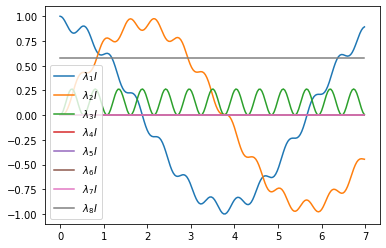

In [37]:
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(10, 20), e_ops=e_ops)

tlist = result.times
for exp, label in zip(result.expect, paulis.labels(3)[1:]):
    plt.plot(tlist, exp, label=f'${label}I$')

plt.legend();

Dressed frame evolution

In [38]:
hgen.set_global_frame('dressed')
qudit_sim.print_hamiltonian(hgen.generate())

LaTeXRepr("\begin{align}H_{\mathrm{static}} & = -0.831| 0,1 \rangle\langle 0,1 | - 3.261| 0,2 \rangle\langle 0,2 | + 0.831| 1,0 \rangle\langle 1,0 | - 2.430| 1,2 \rangle\langle 1,2 | + 0.991| 2,0 \rangle\langle 2,0 | + 0.160| 2,1 \rangle\langle 2,1 | - 2.271| 2,2 \rangle\langle 2,2 | \\ H_{0} & = [\text{cos(-11.661903789690598*t)}]*  \left( 3| 0,1 \rangle\langle 1,0 | + 3| 1,0 \rangle\langle 0,1 | \right) \\ H_{1} & = [\text{sin(-11.661903789690598*t)}]*  \left( -3i| 0,1 \rangle\langle 1,0 | + 3i| 1,0 \rangle\langle 0,1 | \right) \\ H_{2} & = [\text{cos(-6.261260989755812*t)}]*  \left( 4.243| 0,2 \rangle\langle 1,1 | + 4.243| 1,1 \rangle\langle 0,2 | \right) \\ H_{3} & = [\text{sin(-6.261260989755812*t)}]*  \left( -4.243i| 0,2 \rangle\langle 1,1 | + 4.243i| 1,1 \rangle\langle 0,2 | \right) \\ H_{4} & = [\text{cos(-18.9905348418458*t)}]*  \left( 4.243| 1,1 \rangle\langle 2,0 | + 4.243| 2,0 \rangle\langle 1,1 | \right) \\ H_{5} & = [\text{sin(-18.9905348418458*t)}]*  \left( -4.243i| 1,1 

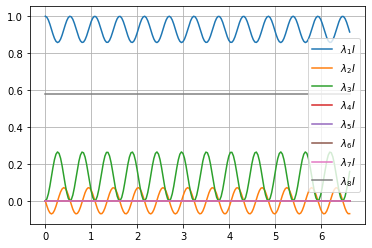

In [39]:
result = qudit_sim.pulse_sim(hgen, psi0=psi0, tlist=(10, 20), e_ops=e_ops)

tlist = result.times
for exp, label in zip(result.expect, paulis.labels(3)[1:]):
    plt.plot(tlist, exp, label=f'${label}I$')

plt.grid()
plt.legend();